In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
df = pd.read_excel('C:/Users/Patyc/OneDrive/Desktop/Dissertation/Data/Skin_clean and treated/Skin_clean_location.xlsx')
df['Location'] = df['Location'].str.strip()
df.loc[df['Location'].eq('Faro') & df['Screening_date'].eq('2022-08-13'), 'Screening_date'] = '2022-08-14'
df.loc[df['Location'].eq('Lisboa') & df['Screening_date'].eq('2023-05-15'), 'Screening_date'] = '2023-05-19'

df.head()

d1 = df.groupby(['Location', 'Screening_date'], as_index=False).size().sort_values(['Location', 'Screening_date'])
d2 = d1.assign(count = d1.groupby(['Location'])['Location'].transform('count'))
d2 = d2[d2['count'].ne(1)]

d2['ndays'] = d2.groupby('Location')['Screening_date'].diff()
d2['nscreens'] = d2['size'].values/d2['ndays'].dt.days
d2

date_range = pd.date_range(start='2022-03-03', end='2024-04-20') #datas mais extremas no dataset

datesdf = pd.DataFrame(date_range, columns=['Screening_date'])

list_dfs = []

groups = d2.groupby('Location')

for _, group in groups:
    list_dfs.append(datesdf.merge(group, how='left').bfill().ffill())

d3 = pd.concat(list_dfs)
d3

# Agrupar por 'Screening_date' e calcular a soma de 'nscreens' para cada data (ou use outra função agregada como média)
d4 = d3.groupby('Screening_date', as_index=False)['nscreens'].sum()

d4

,Screening_date,nscreens
0,2022-03-03,11.169861
1,2022-03-04,11.169861
2,2022-03-05,11.169861
3,2022-03-06,11.169861
4,2022-03-07,11.169861
...,...,...
775,2024-04-16,12.874846
776,2024-04-17,12.874846
777,2024-04-18,12.874846
778,2024-04-19,12.874846


ADD DATE-RELATED VARIABLES

In [3]:
# Criar variável de tendência linear
d4['days_since_start'] = (d4['Screening_date'] - d4['Screening_date'].min()).dt.days

# Se houver um padrão sazonal claro, você pode criar variáveis sazonais
# Por exemplo, seno e cosseno para capturar padrões sazonais anuais
d4['sin_seasonal'] = np.sin(2 * np.pi * d4['days_since_start'] / 365.25)
d4['cos_seasonal'] = np.cos(2 * np.pi * d4['days_since_start'] / 365.25)

In [4]:
df = d4

In [5]:
df

,Screening_date,nscreens,days_since_start,sin_seasonal,cos_seasonal
0,2022-03-03,11.169861,0,0.000000,1.000000
1,2022-03-04,11.169861,1,0.017202,0.999852
2,2022-03-05,11.169861,2,0.034398,0.999408
3,2022-03-06,11.169861,3,0.051584,0.998669
4,2022-03-07,11.169861,4,0.068755,0.997634
...,...,...,...,...,...
775,2024-04-16,12.874846,775,0.692903,0.721031
776,2024-04-17,12.874846,776,0.705204,0.709005
777,2024-04-18,12.874846,777,0.717295,0.696769
778,2024-04-19,12.874846,778,0.729175,0.684328


CORR VARIÁVEIS

                  Screening_date  nscreens  days_since_start  sin_seasonal  \
Screening_date          1.000000 -0.084516          1.000000     -0.289133   
nscreens               -0.084516  1.000000         -0.084516      0.298890   
days_since_start        1.000000 -0.084516          1.000000     -0.289133   
sin_seasonal           -0.289133  0.298890         -0.289133      1.000000   
cos_seasonal            0.123695  0.413998          0.123695      0.038901   

                  cos_seasonal  
Screening_date        0.123695  
nscreens              0.413998  
days_since_start      0.123695  
sin_seasonal          0.038901  
cos_seasonal          1.000000  


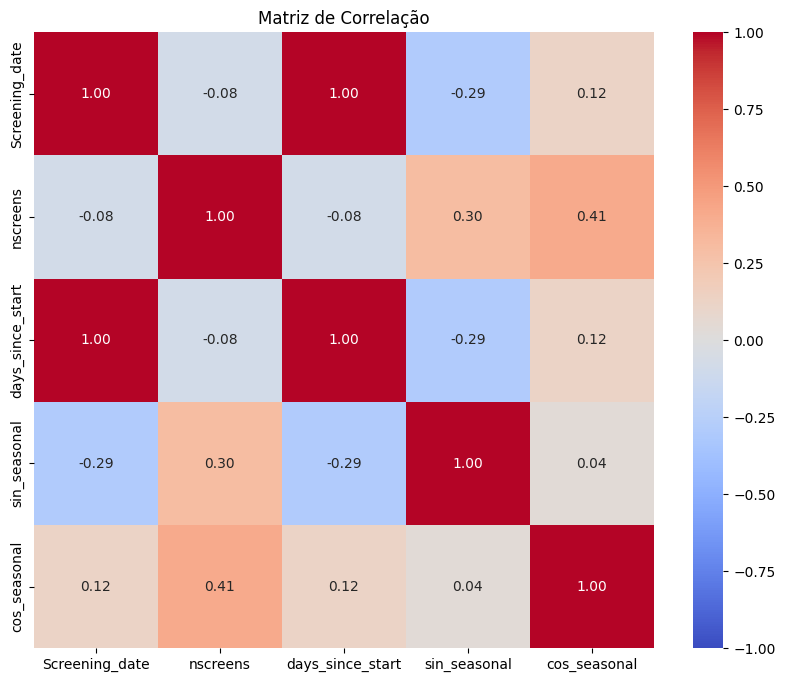

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular a matriz de correlação
correlation_matrix = df[['Screening_date','nscreens', 'days_since_start', 'sin_seasonal', 'cos_seasonal']].corr()

# Exibir a matriz de correlação
print(correlation_matrix)

# Plotar a matriz de correlação como um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Isolar a coluna 'days_since_start'
days_since_start = df[['days_since_start']]

# Aplicar a normalização usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
days_since_start_scaled = scaler.fit_transform(days_since_start)

# Substituir a coluna original pela versão normalizada
df['days_since_start'] = days_since_start_scaled

# Verificar se a normalização foi aplicada corretamente
print(df[['days_since_start']].head())

   days_since_start
0          0.000000
1          0.001284
2          0.002567
3          0.003851
4          0.005135


In [9]:
df

,Screening_date,nscreens,days_since_start,sin_seasonal,cos_seasonal
0,2022-03-03,11.169861,0.000000,0.000000,1.000000
1,2022-03-04,11.169861,0.001284,0.017202,0.999852
2,2022-03-05,11.169861,0.002567,0.034398,0.999408
3,2022-03-06,11.169861,0.003851,0.051584,0.998669
4,2022-03-07,11.169861,0.005135,0.068755,0.997634
...,...,...,...,...,...
775,2024-04-16,12.874846,0.994865,0.692903,0.721031
776,2024-04-17,12.874846,0.996149,0.705204,0.709005
777,2024-04-18,12.874846,0.997433,0.717295,0.696769
778,2024-04-19,12.874846,0.998716,0.729175,0.684328


# MULTIPLE LINEAR REGRESSION MODEL

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming your DataFrame is named 'df'
X = df[['days_since_start', 'sin_seasonal', 'cos_seasonal']]
y = df['nscreens']

In [11]:
y

0      11.169861
1      11.169861
2      11.169861
3      11.169861
4      11.169861
         ...    
775    12.874846
776    12.874846
777    12.874846
778    12.874846
779    12.874846
Name: nscreens, Length: 780, dtype: float64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [28]:
# Supondo que sua coluna 'Screening_date' esteja no formato de data
df['Screening_date'] = pd.to_datetime(df['Screening_date'])

# Definindo a data de corte
cutoff_date = pd.to_datetime('2024-03-01')

# Criando os conjuntos de treinamento e teste com base na data
X_train = df[df['Screening_date'] <= cutoff_date].drop(columns=['nscreens', 'Screening_date'])
y_train = df[df['Screening_date'] <= cutoff_date]['nscreens'].values

X_test = df[df['Screening_date'] > cutoff_date].drop(columns=['nscreens', 'Screening_date'])
y_test = df[df['Screening_date'] > cutoff_date]['nscreens'].values

In [13]:
# Adicionar uma constante aos dados
X_train_sm = sm.add_constant(X_train)
X_test_sm = X_test.copy()  # Certifique-se de que não está sobrescrevendo X_test original
X_test_sm.insert(0, 'const', 1.0)

# print(X_train_sm.head())
# print(X_test_sm.head())

# Ajustar o modelo
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Obter o resumo do modelo
print(model_sm.summary())

# Fazer previsões no conjunto de teste
y_pred = model_sm.predict(X_test_sm)

                            OLS Regression Results                            
Dep. Variable:               nscreens   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     979.9
Date:                Fri, 23 Aug 2024   Prob (F-statistic):          9.21e-235
Time:                        21:21:32   Log-Likelihood:                -289.00
No. Observations:                 624   AIC:                             586.0
Df Residuals:                     620   BIC:                             603.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.3126      0.032  

In [88]:
# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: LR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: LR shuffle
# MAE: 3.12103914438965
# MSE: 13.825351306314532
# RMSE: 3.7182457296841656
# R2: -2.645555064577292
# ME: 3.12103914438965
# MAV: 11.228988121444878
# MPV: 0.25287691348449026
# RME: 0.25287691348449026
# RMAE: 0.25287691348449026

# Modelo: LR split date
# MAE: 3.054812506732243
# MSE: 9.332940627056585
# RMSE: 3.054986190976415
# R2: 0.0
# ME: 3.054812506732243
# MAV: 12.874845651448748
# MPV: 0.23726983526117068
# RME: 0.23726983526117068
# RMAE: 0.23726983526117068

Modelo: LR
MAE: 3.12103914438965
MSE: 13.825351306314532
RMSE: 3.7182457296841656
R2: -2.645555064577292
ME: 3.12103914438965
MAV: 11.228988121444878
MPV: 0.25287691348449026
RME: 0.25287691348449026
RMAE: 0.25287691348449026


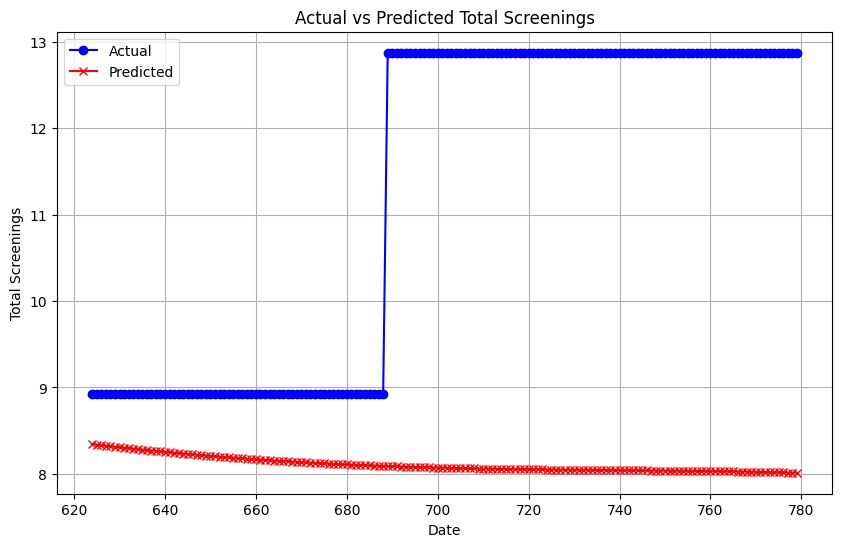

In [50]:
# Visualizar os resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Total Screenings')
plt.title('Actual vs Predicted Total Screenings')
plt.legend()
plt.grid(True)
plt.show()


# GLM MODEL

In [14]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from sklearn.preprocessing import PolynomialFeatures

Gaussian

In [52]:
# Ajustar o modelo GLM com família Gaussian
model_glm = GLM(y_train, X_train_sm, family=Gaussian()).fit()

# Obter o resumo do modelo
print(model_glm.summary())

# Fazer previsões no conjunto de teste
y_pred = model_glm.predict(X_test_sm)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               nscreens   No. Observations:                  624
Model:                            GLM   Df Residuals:                      620
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                         0.14880
Method:                          IRLS   Log-Likelihood:                -289.00
Date:                Tue, 20 Aug 2024   Deviance:                       92.254
Time:                        18:06:15   Pearson chi2:                     92.3
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9910
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.3126      0.032  

In [53]:
print("Modelo: GLM com Gaussian")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: GLM com Gaussian shuffle
# MAE: 3.12103914438965
# MSE: 13.825351306314532
# RMSE: 3.7182457296841656
# R2: -2.645555064577292
# ME: 3.12103914438965
# MAV: 11.228988121444878
# MPV: 0.25287691348449026
# RME: 0.25287691348449026
# RMAE: 0.25287691348449026

# split
# MAE: 3.054812506732243
# MSE: 9.332940627056585
# RMSE: 3.054986190976415
# R2: 0.0
# ME: 3.054812506732243
# MAV: 12.874845651448748
# MPV: 0.23726983526117068
# RME: 0.23726983526117068
# RMAE: 0.23726983526117068

Modelo: GLM com Gaussian
MAE: 3.12103914438965
MSE: 13.825351306314532
RMSE: 3.7182457296841656
R2: -2.645555064577292
ME: 3.12103914438965
MAV: 11.228988121444878
MPV: 0.25287691348449026
RME: 0.25287691348449026
RMAE: 0.25287691348449026


Kernel

In [29]:
# Definir o grau do polinômio
degree = 2

# Criar o transformador polinomial
poly = PolynomialFeatures(degree)

# Ajustar e transformar os dados de treino
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Adicionar uma constante aos dados transformados
X_train_poly_sm = sm.add_constant(X_train_poly)
X_test_poly_sm = sm.add_constant(X_test_poly)

# Ajustar o modelo GLM com família Gaussian
model_glm = GLM(y_train, X_train_poly_sm, family=Gaussian()).fit()

# Obter o resumo do modelo
print(model_glm.summary())

# Fazer previsões no conjunto de teste
y_pred = model_glm.predict(X_test_poly_sm)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  730
Model:                            GLM   Df Residuals:                      721
Model Family:                Gaussian   Df Model:                            8
Link Function:               Identity   Scale:                         0.23803
Method:                          IRLS   Log-Likelihood:                -507.38
Date:                Fri, 23 Aug 2024   Deviance:                       171.62
Time:                        21:23:57   Pearson chi2:                     172.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9882
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2026      0.057    144.177      0.0

In [30]:
print("Modelo: GLM com kernel polinomial")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: GLM com kernel polinomial shuffle =
# MAE: 1.6385284934391673
# MSE: 3.415407657159552
# RMSE: 1.848082156496175
# R2: 0.09940395681177183
# ME: 1.0682178402618139
# MAV: 11.228988121444878
# MPV: 0.1370685597495973
# RME: 0.07316668554799606
# RMAE: 0.1370685597495973

# Modelo: GLM com kernel polinomial split
# MAE: 0.1842976694009006
# MSE: 0.04092089480525704
# RMSE: 0.20228913664667472
# R2: 0.0
# ME: -0.17419408683243018
# MAV: 12.874845651448748
# MPV: 0.014314553695652453
# RME: -0.013529800010676546
# RMAE: 0.014314553695652453


Modelo: GLM com kernel polinomial
MAE: 0.1842976694009006
MSE: 0.04092089480525704
RMSE: 0.20228913664667472
R2: 0.0
ME: -0.17419408683243018
MAV: 12.874845651448748
MPV: 0.014314553695652453
RME: -0.013529800010676546
RMAE: 0.014314553695652453


SVR MODEL

In [31]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

Kernel gaussiano

In [32]:
# Definir o modelo SVR com kernel RBF
model_svr = SVR(kernel='rbf', C=1.0, gamma='scale')

# Ajustar o modelo
model_svr.fit(X_train, y_train)

# "Summary" of the model
print(f"Support Vectors: {model_svr.support_vectors_}")
print(f"Number of Support Vectors: {model_svr.n_support_}")
print(f"Dual Coefficients: {model_svr.dual_coef_}")

# Fazer previsões no conjunto de teste
y_pred = model_svr.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

Support Vectors: [[ 0.          0.          1.        ]
 [ 0.0012837   0.01720158  0.99985204]
 [ 0.00256739  0.03439806  0.99940821]
 [ 0.00385109  0.05158437  0.99866864]
 [ 0.00513479  0.06875541  0.99763355]
 [ 0.00641849  0.0859061   0.99630324]
 [ 0.00770218  0.10303138  0.99467811]
 [ 0.00898588  0.12012617  0.99275863]
 [ 0.01026958  0.1371854   0.99054539]
 [ 0.01155327  0.15420405  0.98803902]
 [ 0.01283697  0.17117706  0.98524028]
 [ 0.01412067  0.18809942  0.98214999]
 [ 0.01540436  0.20496611  0.97876907]
 [ 0.01668806  0.22177216  0.97509851]
 [ 0.01797176  0.23851258  0.97113941]
 [ 0.01925546  0.25518241  0.96689293]
 [ 0.02053915  0.27177674  0.96236033]
 [ 0.06290116  0.74658811  0.66528655]
 [ 0.06418485  0.75792163  0.65234562]
 [ 0.06546855  0.76903086  0.63921165]
 [ 0.06675225  0.77991252  0.62588853]
 [ 0.06803594  0.7905634   0.6123802 ]
 [ 0.06931964  0.80098033  0.59869066]
 [ 0.07060334  0.81116024  0.58482396]
 [ 0.12195122  0.99798874 -0.0633914 ]
 [ 0.123

In [33]:
print("Modelo: SVR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: SVR shuffle
# MAE: 2.264296038650952
# MSE: 8.320614430527984
# RMSE: 2.8845475261343823
# R2: -1.1940316311348926
# ME: 2.1319165808034914
# MAV: 11.228988121444878
# MPV: 0.17817844023869345
# RME: 0.16334565495734618
# RMAE: 0.17817844023869345

# split
# MAE: 0.855297030934349
# MSE: 1.0455520954694157
# RMSE: 1.0225224180766972
# R2: 0.0
# ME: 0.855297030934349
# MAV: 12.874845651448748
# MPV: 0.06643163375229327
# RME: 0.06643163375229327
# RMAE: 0.06643163375229327

Modelo: SVR
MAE: 0.855297030934349
MSE: 1.0455520954694157
RMSE: 1.0225224180766972
R2: 0.0
ME: 0.855297030934349
MAV: 12.874845651448748
MPV: 0.06643163375229327
RME: 0.06643163375229327
RMAE: 0.06643163375229327


Linear Kernel

In [34]:
# Definir o modelo SVR com kernel RBF
model_svr_linear = SVR(kernel='linear', C=1.0)

# Ajustar o modelo
model_svr_linear.fit(X_train, y_train)

# "Summary" of the model
print(f"Support Vectors: {model_svr_linear.support_vectors_}")
print(f"Number of Support Vectors: {model_svr_linear.n_support_}")
print(f"Dual Coefficients: {model_svr_linear.dual_coef_}")

# Fazer previsões no conjunto de teste
y_pred = model_svr_linear.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

Support Vectors: [[ 0.          0.          1.        ]
 [ 0.0012837   0.01720158  0.99985204]
 [ 0.00256739  0.03439806  0.99940821]
 ...
 [ 0.93324775 -0.06017211  0.99818802]
 [ 0.93453145 -0.0429928   0.99907538]
 [ 0.93581515 -0.02580077  0.9996671 ]]
Number of Support Vectors: [536]
Dual Coefficients: [[ 1.          1.          1.          1.          1.          1.
   1.          1.          0.52110044  0.92324953  1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.  

In [35]:
print("Modelo: SVR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: SVR split
# MAE: 3.728239560784236
# MSE: 13.901007581938105
# RMSE: 3.7284055012750565
# R2: 0.0
# ME: 3.728239560784236
# MAV: 12.874845651448748
# MPV: 0.2895754762205412
# RME: 0.2895754762205412
# RMAE: 0.2895754762205412

# Modelo: SVR shuffle
# MAE: 2.919969364714042
# MSE: 12.207737674553028
# RMSE: 3.4939573086334397
# R2: -2.2190125892982735
# ME: 2.919969364714042
# MAV: 11.228988121444878
# MPV: 0.23611663394323434
# RME: 0.23611663394323434
# RMAE: 0.23611663394323434

Modelo: SVR
MAE: 3.728239560784236
MSE: 13.901007581938105
RMSE: 3.7284055012750565
R2: 0.0
ME: 3.728239560784236
MAV: 12.874845651448748
MPV: 0.2895754762205412
RME: 0.2895754762205412
RMAE: 0.2895754762205412


# MLP NN MODEL

In [36]:
from sklearn.neural_network import MLPRegressor

In [37]:
# Definir o modelo MLP com uma camada oculta de 100 neurônios (você pode ajustar os parâmetros conforme necessário)
model_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Ajustar o modelo aos dados de treino
model_mlp.fit(X_train, y_train)

# "Summary" do modelo
print(f"Coefs: {model_mlp.coefs_}")
print(f"Intercepts: {model_mlp.intercepts_}")
print(f"Número de iterações: {model_mlp.n_iter_}")

# Fazer previsões no conjunto de teste
y_pred = model_mlp.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

Coefs: [array([[-2.18060808e-83,  3.65330821e-01,  4.72504692e-01,
         1.48607137e-01, -1.61863807e+00, -3.09944307e-01,
        -1.96057912e+00,  1.16815475e-01,  2.81781753e-01,
         2.81247410e-02,  2.36060105e-49,  5.84039510e-01,
         3.59988056e-01, -2.46152256e-02, -4.30821220e-02,
        -9.32798756e-01, -1.32037906e-01, -9.79355178e-03,
         2.34380075e-01,  1.20753576e-01,  1.42708783e-01,
        -3.17991073e-02, -1.90416897e-01, -2.62475517e-01,
        -1.77784461e-01,  2.57413660e-01,  2.42172703e-02,
         1.78595934e-01,  5.46386582e-01,  4.67951251e-52,
         6.37136125e-03, -5.54539521e-02, -7.66776037e-54,
         1.85558621e-01,  1.57730918e-01,  5.70214914e-01,
        -2.03810250e-01, -3.90873936e-01,  3.33132345e-01,
        -5.99560592e-02, -2.59620525e-01,  2.46798278e-01,
        -2.16645735e-01,  6.41952924e-01, -3.00970954e-01,
         3.39369963e-01,  3.26098911e-02,  4.33424515e-01,
         5.17884706e-01, -2.15722455e-01,  3.860

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [38]:
print("Modelo: MPL NN")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: MPL NN split
# MAE: 0.57195067237758
# MSE: 0.3831831589773254
# RMSE: 0.6190178987536026
# R2: 0.0
# ME: 0.57195067237758
# MAV: 12.874845651448748
# MPV: 0.04442388575844564
# RME: 0.04442388575844564
# RMAE: 0.04442388575844564

# Modelo: MPL NN shuffle
# MAE: 2.1341464300178594
# MSE: 7.114984053864484
# RMSE: 2.66739274458496
# R2: -0.8761234761611807
# ME: 1.9320739206404642
# MAV: 11.228988121444878
# MPV: 0.16923422123541548
# RME: 0.1465925048271817
# RMAE: 0.16923422123541548

Modelo: MPL NN
MAE: 0.57195067237758
MSE: 0.3831831589773254
RMSE: 0.6190178987536026
R2: 0.0
ME: 0.57195067237758
MAV: 12.874845651448748
MPV: 0.04442388575844564
RME: 0.04442388575844564
RMAE: 0.04442388575844564


# LSTM

In [39]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

In [40]:
# Certifique-se de que seus dados estejam no formato adequado para o LSTM
# LSTM espera os dados na forma de [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Definir o modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dense(1))  # Camada de saída

# Compilar o modelo
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Ajustar o modelo aos dados de treino
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# "Summary" do modelo
model_lstm.summary()

# Fazer previsões no conjunto de teste
y_pred = model_lstm.predict(X_test)

print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Flatten y_pred to make it a 1D array
y_pred = y_pred.flatten()

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

Epoch 1/100


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 100.8464
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92.7857 
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.7658
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.1556 
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4130  
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9352 
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2719 
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8495 
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6376 
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5448 
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3150
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1243
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9809 
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9653
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7977 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
Shape of y_test: (50,)
Shape of y_pred: (50, 1)


In [41]:
print("Modelo: LSTM")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: LSTM split
# MAE: 2.70318911916115
# MSE: 7.479376345221571
# RMSE: 2.734844848473414
# R2: 0.0
# ME: 2.70318911916115
# MAV: 12.874845651448748
# MPV: 0.20995895347739357
# RME: 0.20995895347739357
# RMAE: 0.2099589534773935

# Modelo: LSTM shuffle
# MAE: 3.135433435167537
# MSE: 14.765474061446522
# RMSE: 3.842586897058611
# R2: -2.8934525100281303
# ME: 3.135433435167537
# MAV: 11.228988121444878
# MPV: 0.25148288242533834
# RME: 0.25148288242533834
# RMAE: 0.25148288242533834

Modelo: LSTM
MAE: 2.70318911916115
MSE: 7.479376345221571
RMSE: 2.734844848473414
R2: 0.0
ME: 2.70318911916115
MAV: 12.874845651448748
MPV: 0.20995895347739357
RME: 0.20995895347739357
RMAE: 0.20995895347739357


# XGB MODEL

In [94]:
from xgboost import XGBRegressor

In [95]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (730, 3)
y_train shape: (730,)


In [83]:
# Reshape X_train to (722, 8)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

# Similarly reshape X_test if it has the same issue
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [96]:
# Initialize the XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)

# Train the model
xgb_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = xgb_model.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

In [97]:
print("Modelo: XGB")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: XGB split
# MAE: 0.00014796620704871088
# MSE: 2.1893998428381983e-08
# RMSE: 0.0001479662070487109
# R2: 0.0
# ME: 0.00014796620704871088
# MAV: 12.874845651448748
# MPV: 1.14926587125385e-05
# RME: 1.14926587125385e-05
# RMAE: 1.14926587125385e-05

# Modelo: XGB shuffle
# MAE: 2.3041944750678276
# MSE: 9.101598766312536
# RMSE: 3.0168856070975805
# R2: -1.3999664632844762
# ME: 2.304174410718653
# MAV: 11.228988121444878
# MPV: 0.17896905156214762
# RME: 0.17896680340228993
# RMAE: 0.17896905156214762

Modelo: XGB
MAE: 0.00014796620704871088
MSE: 2.1893998428381983e-08
RMSE: 0.0001479662070487109
R2: 0.0
ME: 0.00014796620704871088
MAV: 12.874845651448748
MPV: 1.14926587125385e-05
RME: 1.14926587125385e-05
RMAE: 1.14926587125385e-05
